In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt

## Generate Dataset
The goal here is to train a GAN on points on a unit circle in cartesian coordinates. 
The data set will consist of n linearly spaced points.  

In [2]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [132]:
def create_points_on_circle(n_points, noise=0.0):
    angle = np.linspace(0, 2*np.pi, n_points+1)[:-1]
    radius = np.random.normal(1, noise, (n_points,1))
    return radius*np.vstack((np.cos(angle), np.sin(angle))).T

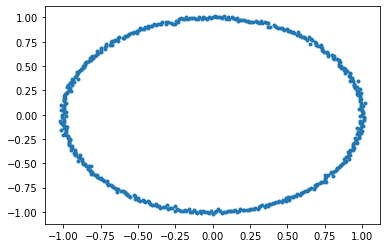

In [136]:
n_points = 500
npdata = create_points_on_circle(n_points, noise=0.01)
plt.plot(npdata[:,0], npdata[:,1], '.')

In [137]:
# create dataloader 
batch_size = len(npdata)

data_tensor = torch.tensor(npdata, dtype=torch.float) # transform to torch tensor

dataset = TensorDataset(data_tensor) # create your datset
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # create your dataloader

## Define Networks

In [138]:
# discriminator network
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self, dim_data):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(dim_data, 8),
                                    #nn.ReLU(),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.1),
                                    nn.Linear(8, 8),
                                    nn.LeakyReLU(),
                                    nn.Linear(8, 1),
                                    nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [139]:
# generator network
class Generator(nn.Module):
    def __init__(self, input_size, dim_data):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(input_size, 16),
                                    nn.Tanh(),
                                    nn.Linear(16, 8),
                                    #nn.BatchNorm1d(50),
                                    nn.Tanh(),
                                    nn.Dropout(0.1),
                                    nn.Linear(8, dim_data),
                                    #nn.LeakyReLU()
                                    #nn.Tanh(),
                                   )
        

    def forward(self, x):
        x = self.layers(x)
        return x

## Training

In [143]:
# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# length of random vector
dim_z = 2
# number of generated data points
num_z = len(npdata)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [146]:
# Initialize BCELoss function
criterion = nn.BCELoss()
#criterion = nn.

fixed_noise = torch.randn(num_z, dim_z, device=device)

# Establish convention for real and fake labels during training
real_label_disc = 1.0 #change to 0.9? one-sided label smoothing
real_label_gen = 1.0
fake_label = 0.0

# networks
n_features = 2
netD = Discriminator(n_features)
netG = Generator(dim_z, n_features)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr)#, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr)#, betas=(beta1, 0.999))

In [147]:
# Lists to keep track of progress
freq_list = []
G_losses_epoch = []
D_losses_epoch = []
D_xs_epoch = []
D_G_z1s_epoch = []
D_G_z2s_epoch = []
iters = 0

In [148]:
# Training Loop (copy pasted training loop and sligthly modified, ofc, we have to do our own...)

# Number of training epochs
num_epochs = 10001

Train_D = True
Train_G = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    
    # For each batch in the dataloader
    G_losses = []
    D_losses = []
    D_xs = []
    D_G_z1s = []
    D_G_z2s = []
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch
        netD.zero_grad()

        # Format batch
        real_cpu = data[0].to(device)
        #add_noise = torch.rand_like(real_cpu)*0.1 + 1
        #real_cpu = real_cpu*add_noise
        b_size = real_cpu.size(0)
        #rand_noise = np.random.normal(0, 0.02)*0
        label = torch.full((b_size,), real_label_disc, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch

        # Generate batch of latent vectors
        noise = torch.randn(b_size, dim_z, device=device)

        # Generate fake batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute error of D as sum over the fake and the real batches
        errD = (errD_real + errD_fake)/2

        # Update D
        if Train_D:
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label_gen)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        #print(f"output shape = {output.shape}")

        # Calculate G's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        if Train_G:
            optimizerG.step()

        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_xs.append(D_x)
        D_G_z1s.append(D_G_z1)
        D_G_z2s.append(D_G_z2)

        iters += 1
        
        
    
    # Save Losses for plotting later
    G_losses_epoch.append(np.mean(G_losses))
    D_losses_epoch.append(np.mean(D_losses))
    D_xs_epoch.append(np.mean(D_xs))
    D_G_z1s_epoch.append(np.mean(D_G_z1s))
    D_G_z2s_epoch.append(np.mean(D_G_z2s))
    
    #if epoch > 25:
    #    Train_G = True
        
    if epoch%50 == 0:
        Train_G = False
        
    if (epoch+25)%50 == 0:
        Train_G = True
        
#     if epoch > 250:
#         Train_G = False
    
#    if epoch > 275:
#        Train_G = True
    
    
#     if G_losses_epoch[-1] > D_losses_epoch[-1]:
#         Train_D = True
#         Train_G = True
#         #print('Train Generator')
#     else:
#         Train_D = True
#         Train_G = True
        #print('Train Discriminator')
    
    # Check how the generator is doing by saving G's output on fixed_noise
    with torch.no_grad():
        fake_t = netG(fixed_noise).detach().cpu().numpy()
    freq_list.append(fake_t)
        
    # Output training stats
    if epoch%1000==0 or epoch==num_epochs - 1:
        print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f | (%.2f, %.2f), (%.2f, %.2f)'
              % (epoch+1, num_epochs,
                 D_losses_epoch[-1], G_losses_epoch[-1], D_xs_epoch[-1], 
                 D_G_z1s_epoch[-1], D_G_z2s_epoch[-1], 
                 freq_list[-1][:,0].min(), freq_list[-1][:,0].max(), freq_list[-1][:,1].min(), freq_list[-1][:,1].max()))

# D(x) from 1 to 0.5
# D(G(z)) from 0 to 0.5

Starting Training Loop...
[1/10001] 	Loss_D: 0.7119	Loss_G: 0.4941	D(x): 0.6215	D(G(z)): 0.6122 / 0.6102 | (-0.33, 0.19), (-0.33, 0.34)
[1001/10001] 	Loss_D: 0.6878	Loss_G: 0.6840	D(x): 0.5114	D(G(z)): 0.5052 / 0.5049 | (-1.23, 1.22), (-0.68, 0.74)
[2001/10001] 	Loss_D: 0.6864	Loss_G: 0.7029	D(x): 0.5050	D(G(z)): 0.4961 / 0.4962 | (-0.93, 1.25), (-1.30, 1.40)
[3001/10001] 	Loss_D: 0.6851	Loss_G: 0.7222	D(x): 0.5042	D(G(z)): 0.4901 / 0.4890 | (-1.17, 1.36), (-1.27, 1.27)
[4001/10001] 	Loss_D: 0.6892	Loss_G: 0.7029	D(x): 0.5091	D(G(z)): 0.4993 / 0.4982 | (-0.99, 1.25), (-1.19, 1.13)
[5001/10001] 	Loss_D: 0.6827	Loss_G: 0.7077	D(x): 0.5127	D(G(z)): 0.4974 / 0.4958 | (-1.07, 1.43), (-1.08, 1.09)
[6001/10001] 	Loss_D: 0.6739	Loss_G: 0.7566	D(x): 0.5066	D(G(z)): 0.4750 / 0.4768 | (-1.06, 1.07), (-1.06, 1.02)
[7001/10001] 	Loss_D: 0.6585	Loss_G: 0.7723	D(x): 0.5253	D(G(z)): 0.4728 / 0.4714 | (-1.04, 1.09), (-1.13, 1.05)
[8001/10001] 	Loss_D: 0.6561	Loss_G: 0.8032	D(x): 0.5169	D(G(z)): 0.4596 

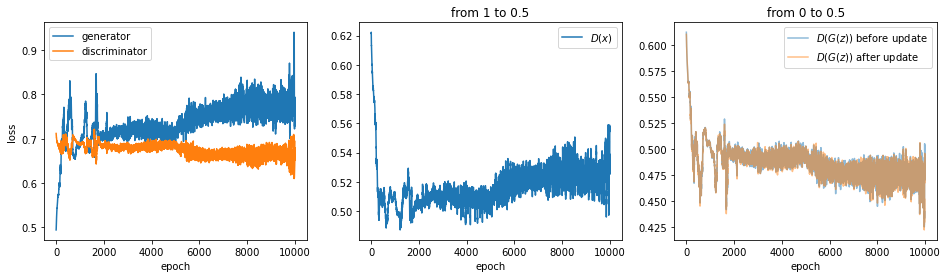

In [149]:
fig, axs = plt.subplots(1,3, figsize=(16,4))
ax=axs[0]
ax.plot(G_losses_epoch, label='generator')
ax.plot(D_losses_epoch, label='discriminator')
ax.set(xlabel='epoch', ylabel='loss')
ax.legend()

ax=axs[1]
ax.plot(D_xs_epoch, label=r"$D(x)$")
ax.legend()
ax.set(title='from 1 to 0.5', xlabel='epoch')

ax=axs[2]
ax.plot(D_G_z1s_epoch, alpha=0.5, label=r"$D(G(z))$ before update")
ax.plot(D_G_z2s_epoch, alpha=0.5, label=r"$D(G(z))$ after update")
ax.legend()
ax.set(title='from 0 to 0.5', xlabel='epoch');

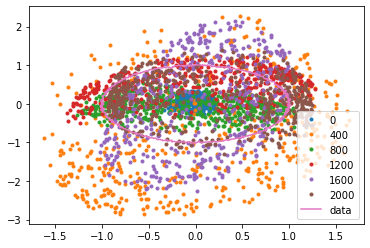

In [163]:
for iteration, points in enumerate(freq_list[:2400]): 
    if iteration%400 == 0:
        plt.plot(points[:,0], points[:,1], '.', label=f"{iteration}")
plt.plot(npdata[:,0], npdata[:,1], '-', label=f"data")
plt.legend()

In [162]:
import imageio
import os

filenames = []
for iteration, points in enumerate(freq_list): 
    if iteration%100 == 0:
        plt.plot(points[:,0], points[:,1], '.', label=f"{iteration}")
        plt.plot(npdata[:,0], npdata[:,1], '-', label=f"data")
        plt.xlim(-3.0, 3.0)
        plt.ylim(-3.0, 3.0)
        plt.legend()
        
        # create file name and append it to a list
        filename = f'circle_imgs/{iteration}.png'
        filenames.append(filename)
        
        plt.savefig(filename)
        plt.close()
        
# build gif
with imageio.get_writer('circle_imgs/mygif.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [164]:
len(freq_list)

10001